In [1]:
%load_ext autoreload
%autoreload 2
import torch

In [2]:
import os
os.chdir('../')

In [3]:
from utils.datasets import get_dataloaders, get_img_size, DATASETS
from disvae.utils.modelIO import save_model, load_model, load_metadata


# fit regressor

## load dataset

In [25]:
test_loader = get_dataloaders("ddsprites2",
                              batch_size=10000,
                              shuffle=True,
                              logger=None)

# subset_indices = # select your indices here
# subset_loader = torch.utils.data.DataLoader(cifar_dataset, batch_size=32, shuffle=True, sampler=SubsetRandomSampler(subset_indices), ...)


## load model

In [5]:
exp_dir = 'cvae_ddsprites2_randSample_klqq=0.1_klu=10_epoch=70_z=7_zu=2'
exp_dir = 'results/' + exp_dir
model = load_model(exp_dir, is_gpu=True)

In [6]:
print(exp_dir)

results/cvae_ddsprites2_randSample_klqq=0.1_klu=10_epoch=70_z=7_zu=2


In [26]:
device = 'cuda'
def infer(model, data):
    with torch.no_grad():
        model.eval()
        device = next(model.parameters()).device

        latents, targets = [], []
        for x, t in data:
            x, xa, xb = x
            x = x.to(device=device)
            xa = xa.to(device=device) 
            xb = xb.to(device=device)

            pmu1, plu1, pmc1, plc1, pmu2, plu2, _, _ = model.encoder(xa, xb)
            post_mean = torch.cat((pmu1, pmc1, pmu2), dim=-1) # just using the mean from xa
            latents.append(post_mean.cpu())
            targets.append(t)
            break

    latents = torch.cat(latents)
    targets = torch.cat(targets)

    return latents, targets

In [27]:
l, t = infer(model, test_loader)

In [13]:
from analysis.metrics import DCIMetrics
metric_data = (l, t)
eastwood = DCIMetrics(metric_data, n_factors=5)


In [28]:
print(t.shape)

torch.Size([10000, 5])


In [29]:
print(l.shape)

torch.Size([10000, 7])


In [30]:
t

tensor([[ 0,  2, 35,  3, 20],
        [ 1,  2, 25, 23, 16],
        [ 0,  5, 35,  6, 16],
        ...,
        [ 2,  1, 25, 21,  2],
        [ 2,  3, 12, 25, 30],
        [ 0,  3,  6, 26,  1]])

In [47]:
metric_data = (l, t)
eastwood = DCIMetrics(metric_data, n_factors=5, regressor='ensemble')
vae_scores = eastwood(model, model_zs = metric_data)


[autoreload of analysis.metrics failed: Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 317, in update_class
    update_instances(old, new)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 280, in update_instances
    ref.__class__ = new
  File "<string>", line 4, in __setattr__
dataclasses.FrozenInstanceError: cannot assign to field '__class__'
]


train error is [0.999    0.995875 0.871625 0.887    0.88425 ]
test error is [0.9955 0.9815 0.4635 0.707  0.716 ]
log losses on test set is [0.03106013 0.08728477 1.78534192 0.95087055 0.90027973]


In [46]:
metric_data = (l[:, 2:5], t)
eastwood = DCIMetrics(metric_data, n_factors=5, regressor='ensemble')
vae_scores = eastwood(model, model_zs = metric_data)

train error is [0.999    0.99625  0.846125 0.519875 0.519875]
test error is [0.996  0.9825 0.4665 0.0355 0.03  ]
log losses on test set is [0.02921322 0.08818242 1.71961831 3.68177482 3.68755071]


In [48]:
metric_data = (l[:, :2], t)
eastwood_unq = DCIMetrics(metric_data, n_factors=5, regressor='ensemble')
vae_scores = eastwood_unq(model, model_zs = metric_data)

train error is [0.5455   0.397375 0.5875   0.84125  0.838125]
test error is [0.453  0.204  0.0355 0.6775 0.697 ]
log losses on test set is [1.03897956 1.78516242 4.01923225 1.01733221 0.95602531]


In [41]:
vae_R = vae_scores.R_coeff

[autoreload of analysis.metrics failed: Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 317, in update_class
    update_instances(old, new)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 280, in update_instances
    ref.__class__ = new
  File "<string>", line 4, in __setattr__
dataclasses.FrozenInstanceError: cannot assign to field '__class__'
]


In [42]:
print(vae_scores)

DCIResults(R_coeff=array([[3.97051720e-04, 6.51209137e-04, 2.29920942e-02, 1.96208403e-02,
        8.76890328e-01],
       [5.29986960e-04, 1.00913223e-03, 2.50577718e-02, 8.65360317e-01,
        2.02310270e-02],
       [3.40770262e-01, 3.80163908e-02, 3.80740170e-01, 2.67289692e-02,
        1.44652122e-02],
       [3.61575388e-01, 9.19565558e-01, 9.40860576e-02, 4.04266038e-02,
        3.39948832e-02],
       [2.96648113e-01, 4.04190498e-02, 4.27540540e-01, 1.34605678e-02,
        2.00297928e-02],
       [2.26741370e-05, 1.44000606e-04, 2.41189004e-02, 1.65035147e-02,
        1.58018223e-02],
       [5.65240959e-05, 1.94659118e-04, 2.54644657e-02, 1.78991874e-02,
        1.85869342e-02]]), disentanglement_scores=array([0.85774916, 0.84772994, 0.34900143, 0.37840698, 0.36956972,
       0.31814469, 0.31067658]), overall_disentanglment=0.5446366114226253, completness_scores=array([0.43313317, 0.82230841, 0.32384403, 0.6780357 , 0.697682  ]))


## visualizing

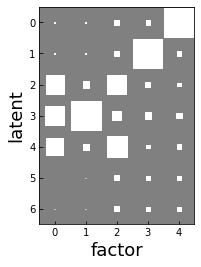

In [43]:
from analysis.hinton import hinton
hinton(vae_R, 'factor', 'latent', fontsize=18)

In [27]:
print(vae_R.shape)

(7, 6)


In [24]:
print(vae_scores.disentanglement_scores)

[0.70315351 0.6942059  0.29207009 0.35471524 0.26990988 0.29582341
 0.27595099]


## new exp 3d-shapes

In [5]:
test_loader = get_dataloaders("dshapes2",
                              batch_size=128,
                              shuffle=False,
                              logger=None)
exp_dir = 'cvae_dshapes2_randSample_klqq=0.1_klu=10_epoch=70_batch=32_z=7_zu=1'
exp_dir = 'results/' + exp_dir
model = load_model(exp_dir, is_gpu=True)

In [8]:
l, t = infer(model, test_loader)

In [24]:
from analysis.metrics import DCIMetrics
metric_data = (l[:,:6], t)
eastwood = DCIMetrics(metric_data, n_factors=6)

In [25]:
vae_scores = eastwood(model, model_zs = metric_data)
vae_R = vae_scores.R_coeff

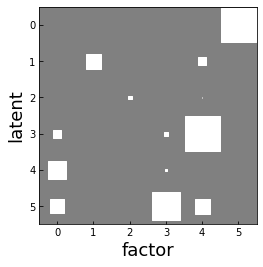

In [26]:
from analysis.hinton import hinton
hinton(vae_R, 'factor', 'latent', fontsize=18)

In [27]:
print(vae_scores.disentanglement_scores)

[1.         0.70023737 0.93821185 0.85113669 0.95553696 0.49920984]


In [28]:
print(vae_scores.overall_disentanglment)

0.7925896979212347


In [16]:
print(vae_R)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 9.13894131e-01]
 [0.00000000e+00 1.74199145e-01 0.00000000e+00 0.00000000e+00
  5.15097845e-02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.08848454e-02 0.00000000e+00
  2.60105544e-04 0.00000000e+00]
 [4.81733732e-02 0.00000000e+00 0.00000000e+00 1.38038315e-02
  9.37402693e-01 0.00000000e+00]
 [2.41154866e-01 0.00000000e+00 0.00000000e+00 3.77611552e-03
  0.00000000e+00 0.00000000e+00]
 [1.54128355e-01 0.00000000e+00 0.00000000e+00 5.90074644e-01
  1.71997119e-01 0.00000000e+00]]


## new exp (batch 64)

In [4]:
test_loader = get_dataloaders("dshapes2",
                              batch_size=128,
                              shuffle=False,
                              logger=None)
exp_dir = 'cvae_dshapes2_randSample_klqq=0.1_klu=10_epoch=70_batch=64_z=7_zu=1'
exp_dir = 'results/' + exp_dir
model = load_model(exp_dir, is_gpu=True)

In [6]:
l, t = infer(model, test_loader)

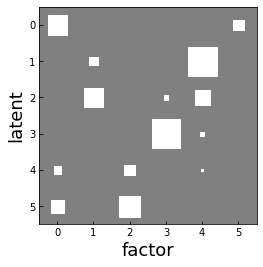

In [7]:
from analysis.metrics import DCIMetrics
metric_data = (l[:,:6], t)
eastwood = DCIMetrics(metric_data, n_factors=6)
vae_scores = eastwood(model, model_zs = metric_data)
vae_R = vae_scores.R_coeff
from analysis.hinton import hinton
hinton(vae_R, 'factor', 'latent', fontsize=18)

## new exp (batch 128)

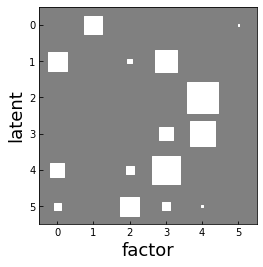

In [9]:
test_loader = get_dataloaders("dshapes2",
                              batch_size=128,
                              shuffle=False,
                              logger=None)
exp_dir = 'cvae_dshapes2_randSample_klqq=0.1_klu=10_epoch=70_z=7_zu=1'
exp_dir = 'results/' + exp_dir
model = load_model(exp_dir, is_gpu=True)
l, t = infer(model, test_loader)
from analysis.metrics import DCIMetrics
metric_data = (l[:,:6], t)
eastwood = DCIMetrics(metric_data, n_factors=6)
vae_scores = eastwood(model, model_zs = metric_data)
vae_R = vae_scores.R_coeff
from analysis.hinton import hinton
hinton(vae_R, 'factor', 'latent', fontsize=18)

In [10]:
print(vae_scores.overall_disentanglment)

0.7280441960556944
